# fysica experiment modelauto

## code

### libs

In [1]:
#low-level
import os
import itertools
import warnings

#math
import math
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

#rendering
import matplotlib.pyplot as plt

import bokeh
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.util.hex import hexbin

import ipywidgets as widgets
from IPython.display import display, IFrame, Markdown, Video, Math
from ipywidgets import Tab, HBox,VBox

import sympy as sym   #latexformatter
from sympy import Matrix

output_notebook()

#SHEET LINK
SHEET = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQktlNgJ3k3vPL3pqmdAEEfqjSIBkk37wvb8J8NlhUjhcs0t9gm69-Q0YUNmlb0PcHGW-4QUMxORlgo'
warnings.filterwarnings('ignore')

Loading BokehJS ...

### rendering backend

In [2]:
def intab(widgets, names): 
    tab = widgets.Tab(children=widgets)
    for i, name in enumerate(names):
        tab.set_title(i, 'name')
        

folder_path = './vids/'
video_files = os.listdir(folder_path)

#dropdown widget
video_dropdown = widgets.Dropdown(
    options=video_files,
    description='Select video:',
    value=video_files[0]
)

#display video functie
def display_video(filename):
    video_path = folder_path + filename
    display(Video(video_path, width=400))

#interactieve widget
video_interactive = widgets.interactive(
    display_video, filename=video_dropdown
)

### dataframe pre-processing

In [3]:
#dataframe pre-processing
df = pd.read_csv(SHEET + '/pub?gid=0&single=true&output=csv', decimal=",")

def convert_data_types(df, col_data_types):
    for col, data_type in col_data_types.items():
        if '-' in col:
            start, end = col.split('-')
            cols = df.loc[:, start:end].columns
            df[cols] = df[cols].astype(data_type)
        else:
            try:
                df[col] = df[col].astype(data_type)
            except ValueError:
                # handle empty cells
                df[col] = pd.to_numeric(df[col], errors='coerce').astype(data_type)
                
convert_data_types(df, {'testID': str, 'vidID': str, 'graden': float, 't0-t40': float})

### math

In [4]:
def Flex_Exponent(x, a, b, c):
    return a * np.exp(-b * x) + c

def Flex_Sin(x, a, b, c, d):
    return a * np.sin(b * np.radians(x) + c) + d
    
def Fit_Exponent(x_data, y_data):
    #initial guess
    p0 = (y_data[0], 1, y_data[-1])
    #regressie
    return curve_fit(Flex_Exponent, x_data, y_data, p0=p0)

### plots backend

In [5]:
def print_matrix(array):
    matrix = ''
    for row in array:
        try:
            for number in row:
                matrix += f'{number}&'
        except TypeError:
            matrix += f'{row}&'
        matrix = matrix[:-1] + r'\\'
    display(Math(r'\begin{bmatrix}'+matrix+r'\end{bmatrix}'))
    
def DfPlot(idf):
    source = ColumnDataSource(idf)
    p = figure(title='Test Results', x_axis_label='graden', y_axis_label='Time')
    p.scatter(x='graden', y='t40', size=10, source=source, color='blue', legend_label='t40')
    p.scatter(x='graden', y='t80', size=10, source=source, color='red', legend_label='t80')
    p.legend.location = 'top_right'
    # Add hover tool to show metadata on hover
    p.add_tools(HoverTool(tooltips=[
            ('Test ID', '@testID'),
            ('Video ID', '@vidID')]))
    show(p)
    

def Plot_FitExponent(popt, pcov, x_data, y_data):
    #x_data = df['graden'].to_numpy()
    #y_data = df['t40'].to_numpy()
    #popt, pcov = Fit_Exponent(x_data, y_data)

    plt.scatter(x_data, y_data, label='Data')
    plt.plot(range(60), [Flex_Exponent(i, popt[0], popt[1], popt[2]) for i in range(60)], label='Fit', color='Red')
    plt.legend()
    plt.show()
    
    
def Tex_FitExponent(popt, pcov, x_data, y_data):
    #truncated
    a_trunc = np.round(popt[0], 2)
    b_trunc = np.round(popt[1], 2)
    c_trunc = np.round(popt[2], 2)
    display(Markdown(f"$f(x) = {{ a \cdot e^{{-b \cdot x}} }} + c$"))
    display(Markdown(f"$f(x) = {{ {a_trunc} \cdot e^{{-{b_trunc} \cdot x}} }} + {c_trunc}$"))
    display(Markdown(f"covariatie matrix"))
    print_matrix(pcov)

    
def Plot_FitSin(popt, pcov, x_data, y_data):
    #x_data = df['graden'].to_numpy()
    #y_data = df['t40'].to_numpy()
    #popt, pcov = Fit_Exponent(x_data, y_data)
    
    x_data = np.arange(60)
    y_data = [Flex_Exponent(i, popt[0], popt[1], popt[2]) for i in range(60)]
    p0=(1, 1, -np.pi, 1.25)
    plt.plot(x_data, y_data, label='Data')
    plt.plot(range(380), Flex_Sin(range(380), *p0), label='P0')
    plt.legend()
    plt.show()

## uitleg

#### beschrijvig experiment:
Het experiment was gericht op het onderzoeken van het effect van verschillende hellingshoeken op de verstreken tijd die een modelauto nodig heeft om over een baan te rollen. Om dit te bereiken, werden zes verschillende hellingshoeken (10°, 20°, 30°, 40°, 50° en 60°) getest, en voor elke hoek werden drie proeven uitgevoerd om de betrouwbaarheid van de gegevens te waarborgen.

#### protocol: 
Tijdens het experiment werd de modelauto vanaf een vast startpunt boven aan de helling losgelaten en kon vrij over de baan rollen. De verstreken tijd werd geregistreerd toen de auto specifieke afstanden passeerde (0, 10, 20, 30, 40, 50, 60, 70 en 80 centimeter). Deze afstanden zijn gekozen om de gemiddelde snelheid van de auto op verschillende punten langs de helling vast te leggen. Hiervoor gebruiken we een combinatie van automatishe beelverwerking (met opencomputer vision, kinovea) en manuele herziening.
We proberen ervoor te zorgen dat de modelauto word losgelaten op exact $T_0$ met $v(0)=0$ en $a(0)=0$

<figure><img src="files/tracing_demo.jpg" width="100"/><figcaption>Fig.1 visualistaie van de data verzameld door het Kinovea + OpenCV proces.</figcaption></figure> 

Het moet wel vermeld worden dat het traject van de modelauto tijdens de experimenten mogelijk niet perfect recht was. Als zodanig kunnen er onnauwkeurigheden in de gegevens zijn als gevolg van de afwijking van de auto van het beoogde pad. We hebben enkele correcties hiervoor toegepast. Dusalnietemin is de data door onze herhaling nogsteeds reflectief van de werkelijkheid.

#### Concluderend: 
dit experiment toont de relatie tussen de hellingshoek en de verstreken tijd voor een model auto die over een baan rolt. Over het algemeen geven de bevindingen aan dat <mark>steilere hellingen resulteren in snellere verstreken tijden</mark>. Wij varwachte dat de relatie tussen de hoek en de verstreken tijden een sin als factor zou hebben aangezien dit een factor was in ons hypothetis model; maar <mark>de relatie tussen de hoek en de versteken tijden is exponetieel</mark>. De gegevens laten een significante afname van de verstreken tijd zien naarmate de hellingshoek toeneemt van 10° tot 60°. De resultaten tonen ook dat de <mark>versnelling</mark> van de auto snel toeneemt in de beginfasen van de helling, maar geleidelijk afneemt naarmate hij de bodem nadert. <mark>De relatie tussen de positie en tijd is dus logarithmisch</mark>.


### data

In [6]:
output1 = widgets.Output()
with output1:
    display(IFrame(SHEET + '/pubhtml?gid=0&amp;single=true&amp;widget=true&amp;headers=false', width=1000, height=350))
    print("sheet html: "+SHEET+"/pubhtml")
    print("share link: "+"https://docs.google.com/spreadsheets/d/1kdDTN5RdBIJVKG44c6-xtkCdsJTEenp-Y1DXJ6M3_lI/edit?usp=sharing")
output2 = widgets.Output()
with output2:
    print(df.dtypes)

output3 = widgets.Output()
with output3:
    display(df)

output4 = VBox(children=[video_interactive])

#tabs tonen
tab = widgets.Tab(children=[output1, output2, output3, output4])
tab.set_title(0, 'sheet embed')
tab.set_title(1, 'Data Types')
tab.set_title(2, 'Data Frame')
tab.set_title(3, 'data source videos')
display(tab)
DfPlot(df)

## resultaten

In [7]:
XData = df['graden'].to_numpy()
YData = df['t40'].to_numpy()
OptimalParameter, CovMartix = Fit_Exponent(XData, YData)

plotfit1tab = widgets.Output()
with plotfit1tab:
    Plot_FitExponent(OptimalParameter, CovMartix, XData, YData)
    
fit1latexresultstab = widgets.Output()
with fit1latexresultstab:
    Tex_FitExponent(OptimalParameter, CovMartix, XData, YData)
    
plotsinfittab = widgets.Output()
with plotsinfittab:
    Plot_FitSin(OptimalParameter, CovMartix, XData, YData)
    
#tabs tonen
tab = widgets.Tab(children=[plotfit1tab, fit1latexresultstab, plotsinfittab])
tab.set_title(0, 'plot fit')
tab.set_title(1, 'results')
tab.set_title(2, 'sin fit')
display(tab)

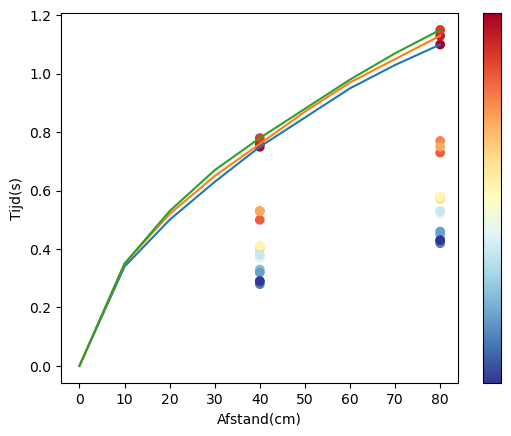

In [8]:
distance_between_points = 10.0
distances = [i * distance_between_points for i in range(9)]

for _, row in df.iloc[:3].iterrows():
    times = row[['t0', 't10', 't20', 't30', 't40', 't50', 't60', 't70', 't80']]
    plt.plot(distances, times, label = str(row['testID']))
#other angles

num_rows = len(df['testID'])
colors = np.linspace(0, 1, num_rows)

# Create a scatter plot with gradually colored points
plt.scatter([40 for _ in range(num_rows)], df['t40'], c=colors, cmap='RdYlBu')
plt.scatter([80 for _ in range(num_rows)], df['t80'], c=colors, cmap='RdYlBu')

# Add a colorbar to show the mapping of colors to values
cbar = plt.colorbar()
cbar.ax.invert_yaxis()  # Invert the colorbar
cbar.set_ticks([]) 

# Add axis labels and a title to the plot
plt.xlabel('Afstand(cm)')
plt.ylabel('Tijd(s)')
plt.show()